# Task Information
## Goal

Submit automated predictions of lesion segmentation boundaries within dermoscopic images.

![Task 1 example segmentation boundaries](https://challenge2018.isic-archive.com/wp-content/uploads/2018/04/task1.png)

## Data
### Input Data

The input data consists of dermoscopic lesion images in JPEG format.

***All lesion images are named using the scheme ISIC_<image_id>.jpg, where <image_id> is a 7-digit unique identifier. EXIF tags in the images have been removed; any remaining EXIF tags should not be relied upon to provide accurate metadata.***

The lesion images were acquired with a variety of [dermatoscope types](https://dermoscopedia.org/Principles_of_dermoscopy), from all anatomic sites (excluding mucosa and nails), from a historical sample of patients presented for skin cancer screening, from several different institutions. Every lesion image contains exactly one primary lesion; other fiducial markers, smaller secondary lesions, or other pigmented regions may be neglected.

The distribution of disease states represent a modified “real world” setting whereby there are more benign lesions than malignant lesions, but an over-representation of malignancies.

### Response Data

The response data consists binary mask images in PNG format, indicating the location of the primary skin lesion within each input lesion image.

***Mask images are named using the scheme ISIC_<image_id>_segmentation.png, where <image_id> matches the corresponding lesion image for the mask.***

***Mask images must have the exact same dimensions as their corresponding lesion image. Mask images are encoded as single-channel (grayscale) 8-bit PNGs (to provide lossless compression), where each pixel is either:***

* 0: representing the background of the image, or areas outside the primary lesion
* 255: representing the foreground of the image, or areas inside the primary lesion

As the primary skin lesion is a single contiguous region, mask images should also contain only a single contiguous foreground region, without any disconnected components or holes. The foreground region may be of any size (including the entire image) and may abut the borders of the image.


### Ground Truth Provenance

Mask image ground truth (provided for training and used internally for scoring validation and test phases) data were generated using several techniques, but all data were reviewed and curated by practicing dermatologists with expertise in dermoscopy.

Ground truth segmentations were generated by either:

fully-automated algorithm, reviewed and accepted by a human expert
a semi-automated flood-fill algorithm, with parameters chosen by a human expert
manual polygon tracing by a human expert

In [99]:
import cv2
import os
import sys
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt

from math import floor

### Generate data
The DataGeneratorerator class is used for building generators for training and testing the model.

Yes. The pixels values in our dataset are in range of 0-255. But if u look into the label images, you can see this is caused by the edge information of the segmentation. You may want to normalise the image and round all values to 0 or 1 only. So the idea is convert the image into binary image yourself

In [100]:
class DataGenerator(keras.utils.Sequence):  
    def __init__(self, ids, path, batch_size=10, image_size=128):
        """Initialization"""
        self.ids = ids
        self.path = path
        self.batch_size = batch_size  # Number of training samples at one time
        self.image_size = image_size # size of the pics
        self.on_epoch_end()
        
    def __load__(self, id_name):
        """load each image from local file path"""
        # file path
        image_path = os.path.join(self.path, "images", id_name) + ".jpg"  # train image
        mask_path = os.path.join(self.path, "masks", id_name) + "_segmentation.png"  # segmentation image
        
        # Read the original image and the correctly segmented image separately
        # Since out image is in GrayScale form but we need image in 3 channel form
        image = cv2.imread(image_path, 1)  # Load color imgs
        image = cv2.resize(image, (self.image_size, self.image_size))  # adjust size
        mask = np.zeros((self.image_size, self.image_size, 1))  # 128 * 128 * 1
        _mask = cv2.imread(mask_path, -1)  # cv2.IMREAD_UNCHANGED
        _mask = cv2.resize(_mask, (self.image_size, self.image_size))
        _mask = np.expand_dims(_mask, axis=-1)
        mask = np.maximum(mask, _mask)  # Select maximum
        
        # normalize the images in range [0, 1]
        image = image/255.0
        mask = mask/255.0
        
        return image, mask
    
    def __getitem__(self, index):
        """Generate one batch of data : Returns i'th batch"""
        if (index + 1)*self.batch_size > len(self.ids):
            self.batch_size = len(self.ids) - index*self.batch_size
        
        # Take the batch of directories
        files_batch = self.ids[index*self.batch_size : (index + 1)*self.batch_size]
        
        image = []
        mask  = []
        
        # pass each directory name to __load__() method, where we extract both image and masks and perform operations.
        for id_name in files_batch:
            _img, _mask = self.__load__(id_name)
            image.append(_img)
            mask.append(_mask)
            
        image = np.array(image)
        mask  = np.array(mask)
        
        return image, mask   # Return array
    
    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        pass
    
    def __len__(self):
        """Denotes the number of batches per epoch : Returns number of batches"""
        return int(np.ceil(len(self.ids)/float(self.batch_size)))

### Hyperparameters

In [102]:
# Set some parameters
image_size = 128  # 384
img_channels = 3
batch_size = 20

path = "./dataset/ISIC2018_Task1-2_Training_Data/" 
train_path = "./dataset/ISIC2018_Task1-2_Training_Data/images" # Training set path

## Training Ids
train_ids = []
for files in os.walk(train_path):  # Traverse directory
       for name in files:
              train_ids.append(name)

train_ids = train_ids[2]  # Get file name
train_ids = [i.split('.', 1)[0] for i in train_ids]  # remove .jpg suffix

val_data_size = floor(len(train_ids) * 0.16)  # Validation set size
test_data_size = floor(val_data_size * 0.5)  # test set size

valid_test_ids = train_ids[:val_data_size]
test_ids = valid_test_ids[:test_data_size]
valid_ids = valid_test_ids[test_data_size:]

train_ids = train_ids[val_data_size:]  # Data is divided into 3 parts

There isn’t a set standard for this. For smaller datasets under 100 samples I would do a 60,20,20 split. The training set proportion can be much larger if you have a massive dataset. For 10k images you could use 9k for training, 500 for validation and 500 for testing. 

Unfortunately with small datasets, you kind of have to sacrifice the training set to properly validate your model.

In [104]:
ids=valid_ids + train_ids + test_ids
print("No. of images = ", len(ids))

print("length of train_set = ", len(train_ids))
print("length of validtion_set = ", len(valid_ids))
print("length of test_set = ", len(test_ids))

No. of images =  2594
length of train_set =  2179
length of validtion_set =  208
length of test_set =  207


In [105]:
gen = DataGenerator(train_ids, path, batch_size=batch_size, image_size=image_size)#读取训练用的图片

# Read training pictures
x, y = gen.__getitem__(0)
print("first image shape: ", x.shape, y.shape)
# x1, y1 = gen.__getitem__(1)
# print("second image shape:", x1.shape, y1.shape)
# if x.shape == x1.shape and y.shape == y1.shape:
#     print("same!")
# else:
#     print("there is something wrong with resizing...")

first image shape:  (20, 128, 128, 3) (20, 128, 128, 1)


### Verify whether the image is successfully read

random number:  11


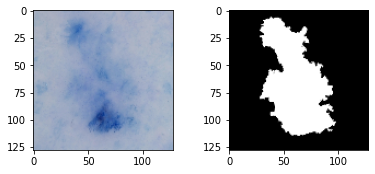

In [106]:
n = random.randint(0, len(x) - 1) # Random number within the number of pictures
print("random number: ", n)
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4) # Adjust the page layout
ax = fig.add_subplot(1, 2, 1) # the first plot
ax.imshow(x[n])
ax = fig.add_subplot(1, 2, 2) # the sec plot
ax.imshow(np.reshape(y[n], (image_size, image_size)), cmap="gray")

#### The UNet is a ‘U’ shaped network which consists of three parts: 

1. The Contracting/Downsampling Path
2. Bottleneck
3. The Expanding/Upsampling Path

### Downsampling Path
It consists of two 3×3 convolutions (unpadded convolutions), each followed by a rectified linear unit (ReLU) and a 2×2 max pooling operation with stride 2 for downsampling. At each downsampling step we double the number of feature channels.

### Upsampling Path
Every step in the expansive path consists of an upsampling of the feature map followed by a 2×2 convolution (“up-convolution”), a concatenation with the correspondingly feature map from the downsampling path, and two 3×3 convolutions, each followed by a ReLU.

### Skip Connection
The skip connections from the downsampling path are concatenated with the feature map during upsampling path. These skip connections provide local information to global information while upsampling.

### Final Layer
At the final layer a 1×1 convolution is used to map each feature vector to the desired number of classes.

### Advantages
- The UNet combines the location information from the downsampling path to finally obtain a general information combining localisation and context, which is necessary to predict a good segmentation map.
- No Dense layer is used, so image sizes can be used.

In [107]:
from tensorflow.keras import layers, models, Sequential, backend
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, Activation, GlobalAveragePooling2D
from tensorflow.keras.layers import Concatenate, Lambda, Input, ZeroPadding2D, AveragePooling2D, DepthwiseConv2D, Reshape

# from tensorflow.keras import layers, models, Sequential, backend
# from tensorflow.keras.layers import Conv2D, Concatenate, Activation, Input, DepthwiseConv2D

In [108]:
# Build U-Net model
# Note we make our layers varaibles so that we can concatenate or stack
# imput image tile
def relu6(x):
    return K.relu(x, max_value=6)

def conv_block (x, nb_filter,activ, kernel=(1,1), stride=(1,1), name=None):
    x = Conv2D(nb_filter, kernel, strides=stride, padding='same', use_bias=False)(x)
    if activ == 1:
        x = Activation(relu6, name=name)(x)
    else:
        x = keras.activations.linear(x)
    return x

def down_block(x, filters):
    c = conv_block(x, filters,1)
    p = DepthwiseConv2D((3,3), strides=(2, 2), depth_multiplier=1, padding='same')(c)
    p = Activation(relu6)(p)
    p = conv_block(p, filters,0)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding="same", strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

In [109]:
# Next we build the complete UNet architecture in the UNet function. 
# This function uses the down_block, bottleneck and up_block to build the UNet.
def UNet():
    f = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input((image_size, image_size, 3))
    
    p0 = inputs
    c1, p1 = down_block(p0, f[0]) 
    c2, p2 = down_block(p1, f[1]) 
    c3, p3 = down_block(p2, f[2])
    c4, p4 = down_block(p3, f[3]) 
    
    bn = bottleneck(p4, f[4])
    
    u1 = up_block(bn, c4, f[3]) #8 -> 16
    u2 = up_block(u1, c3, f[2]) #16 -> 32
    u3 = up_block(u2, c2, f[1]) #32 -> 64
    u4 = up_block(u3, c1, f[0]) #64 -> 128
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(u4)
    model = keras.models.Model(inputs, outputs)
    return model

Model: "functional_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_95 (Conv2D)              (None, 128, 128, 16) 48          input_6[0][0]                    
__________________________________________________________________________________________________
activation_40 (Activation)      (None, 128, 128, 16) 0           conv2d_95[0][0]                  
__________________________________________________________________________________________________
depthwise_conv2d_20 (DepthwiseC (None, 64, 64, 16)   160         activation_40[0][0]              
______________________________________________________________________________________

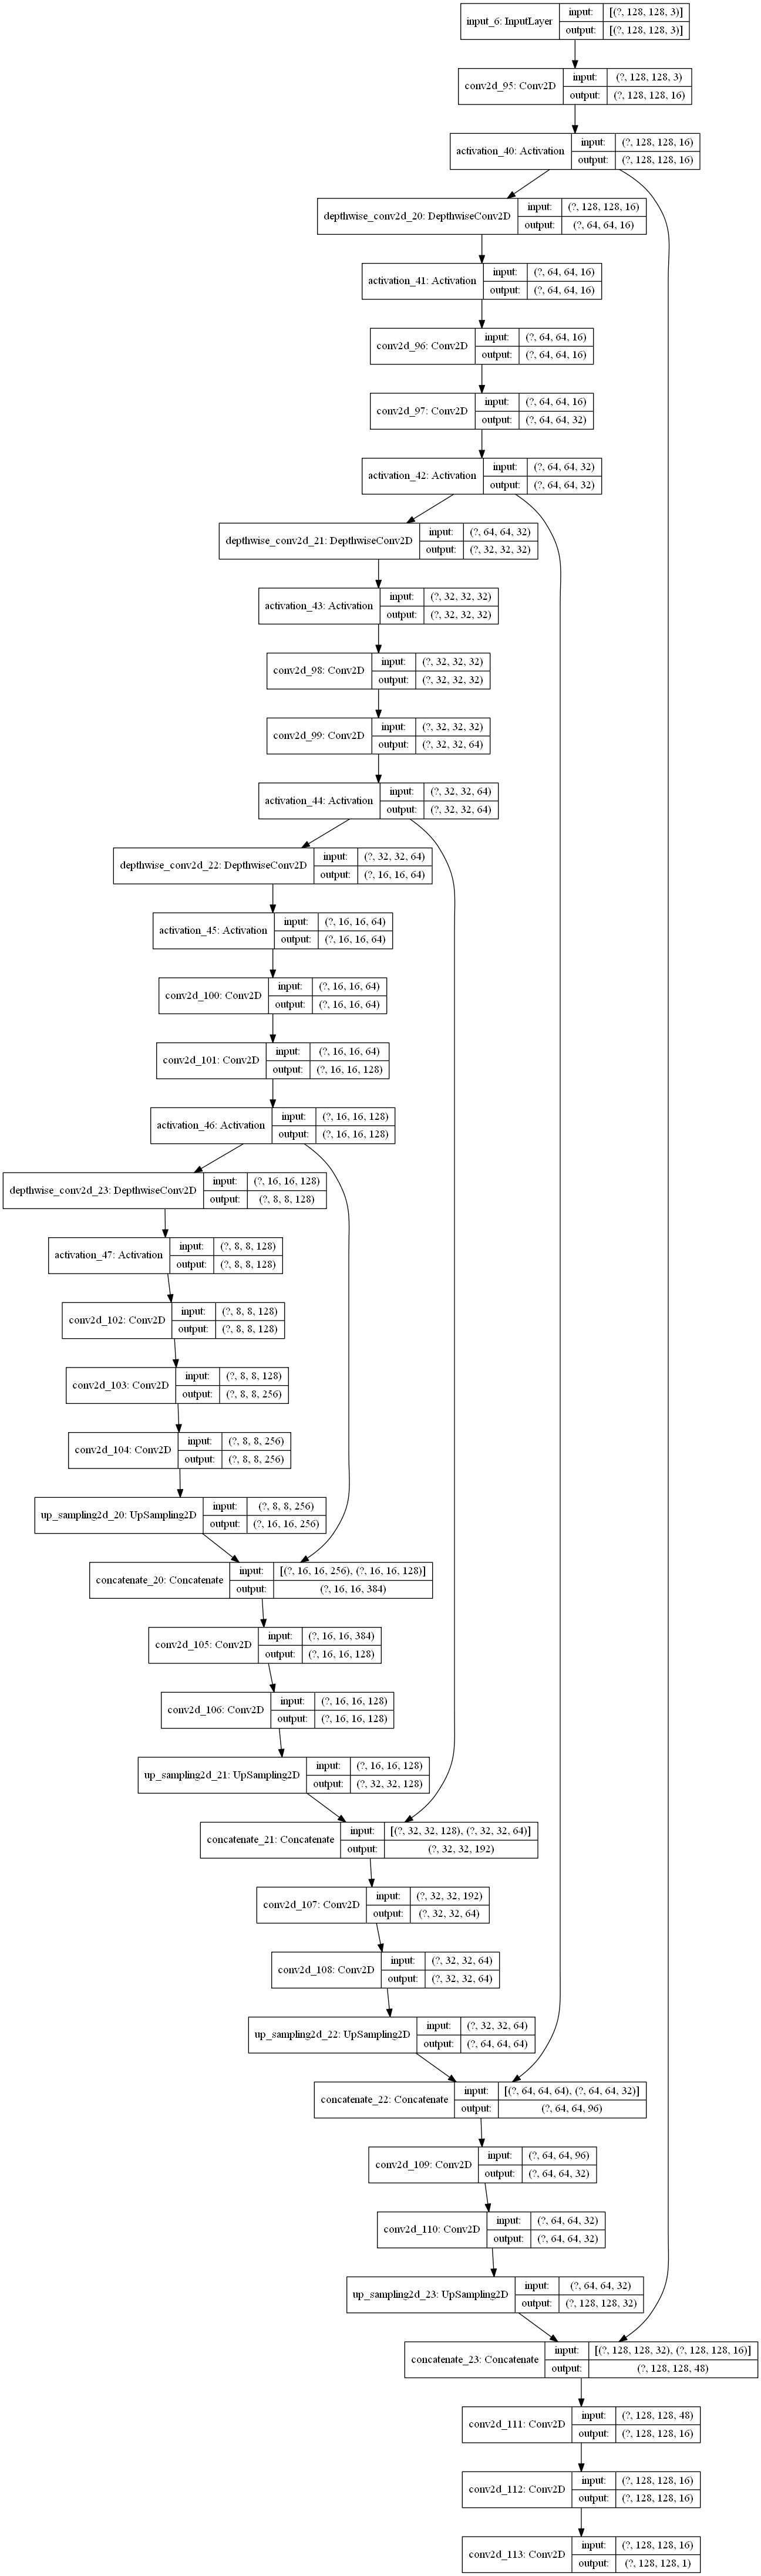

In [110]:
# After we finished building the UNet model, we compile this model. 
# For this experiment, we uses Adam optimizer, binary crossentropy as loss function 
# and accuracy as the metric to measure the performance.
model = UNet()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["acc", dice_coef])#优化器，损失函数，评估标准
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)

### Training
Here we create the two data generator, one for the training using the training data and other using the validation data. After that we start training the model.

In [111]:
train_gen = DataGenerator(train_ids, path)
valid_gen = DataGenerator(valid_ids, path, 3, 128)

train_steps = len(train_ids)//batch_size
valid_steps = len(valid_ids)//batch_size

# Train the model by batch
history = model.fit_generator(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps, epochs = 10)
model.save("U_Net_Model_Improved.h5")  # Save model

Epoch 1/10
108/108 [==============================] - 125s 1s/step - loss: 0.4609 - acc: 0.8211 - dice_coef: 0.2303 - val_loss: 0.6639 - val_acc: 0.6895 - val_dice_coef: 0.3286
Epoch 2/10
108/108 [==============================] - 114s 1s/step - loss: 0.4127 - acc: 0.8285 - dice_coef: 0.2876 - val_loss: 0.5119 - val_acc: 0.7643 - val_dice_coef: 0.4234
Epoch 3/10
108/108 [==============================] - 82s 764ms/step - loss: 0.3811 - acc: 0.8416 - dice_coef: 0.3073 - val_loss: 0.5770 - val_acc: 0.7646 - val_dice_coef: 0.4187
Epoch 4/10
108/108 [==============================] - 15s 140ms/step - loss: 0.3890 - acc: 0.8627 - dice_coef: 0.3127 - val_loss: 0.4707 - val_acc: 0.7783 - val_dice_coef: 0.4946
Epoch 5/10
108/108 [==============================] - 15s 139ms/step - loss: 0.3640 - acc: 0.8584 - dice_coef: 0.3013 - val_loss: 0.4540 - val_acc: 0.7773 - val_dice_coef: 0.5212
Epoch 6/10
108/108 [==============================] - 16s 147ms/step - loss: 0.3690 - acc: 0.8500 - dice_coef

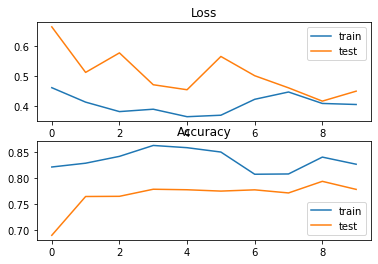

In [112]:
from matplotlib import pyplot
# plot loss during training
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(history.history['acc'], label='train')
pyplot.plot(history.history['val_acc'], label='test')
pyplot.legend()
pyplot.savefig('resources/acc_loss_improved_unet.png',bbox_inches='tight')
pyplot.show()

### Make predictions
Let's make predictions both on the test set, the val set and the train set (as a sanity check). Generates output predictions for the input samples.\
note: Remember to load the best-saved model if you've used early stopping.
***return***: Numpy array(s) of predictions.

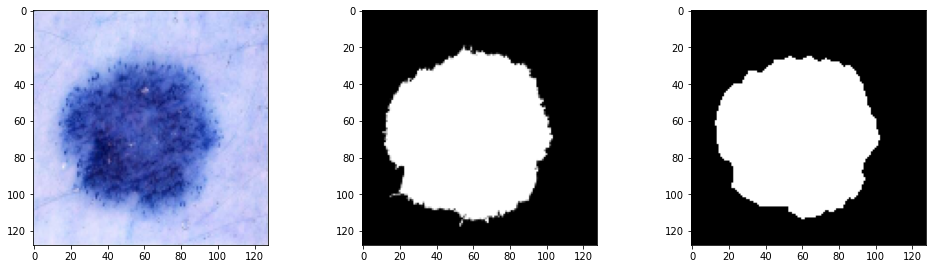

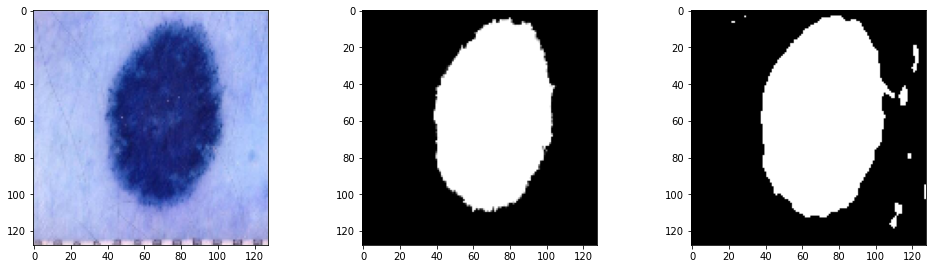

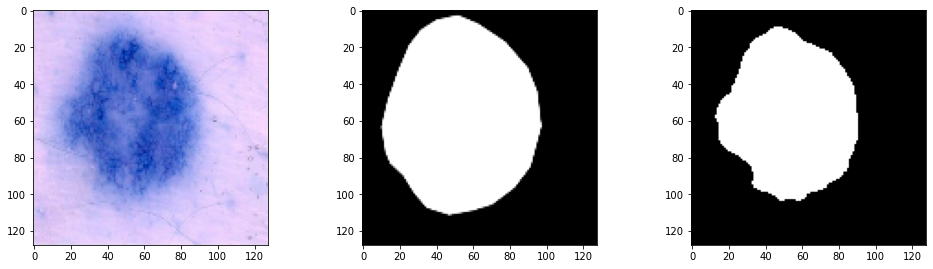

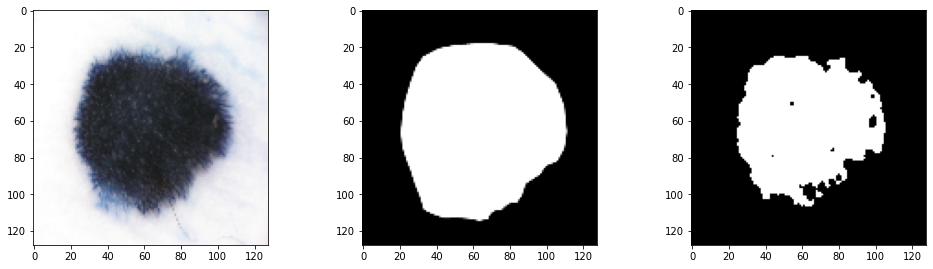

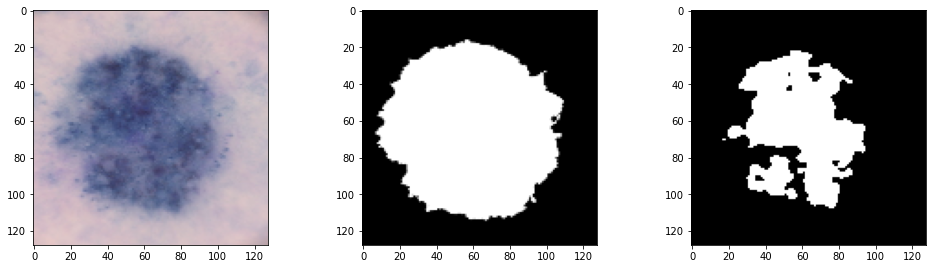

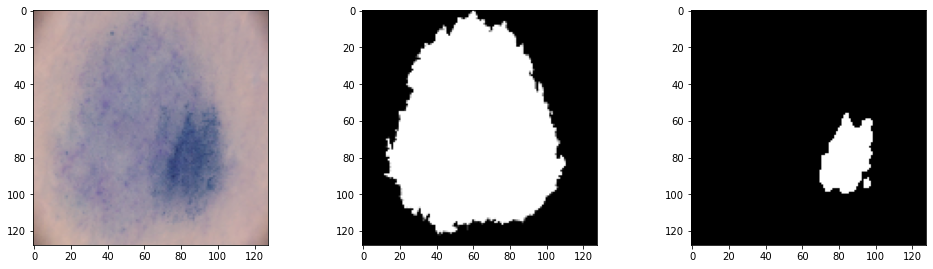

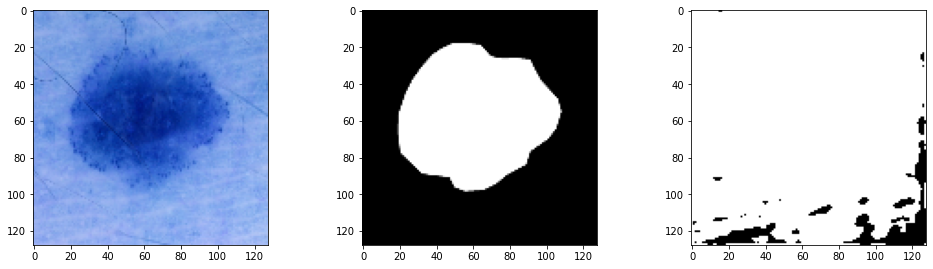

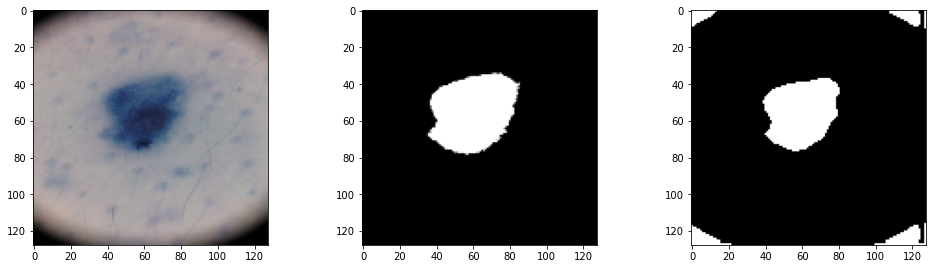

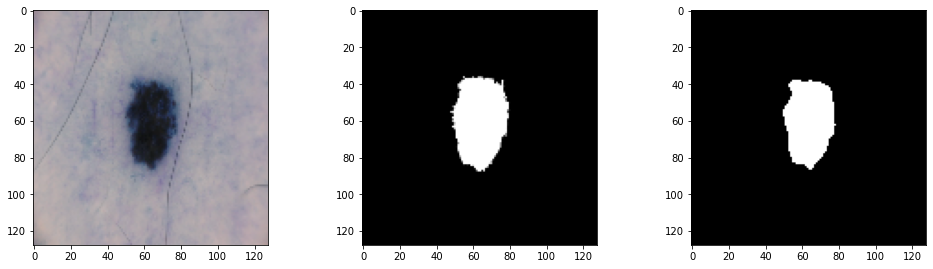

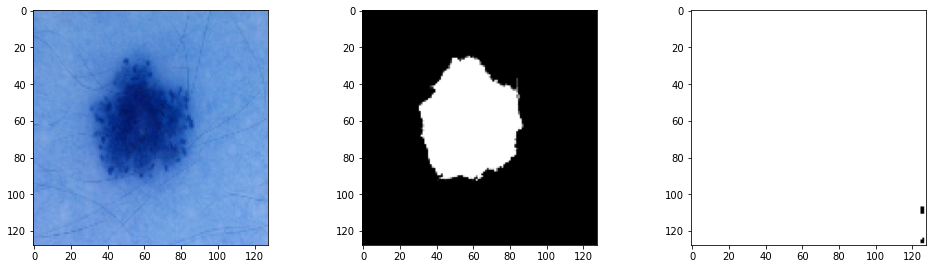

In [114]:
for i in range(0,10):
    x, y = valid_gen.__getitem__(i)
    result = model.predict(x)
    
    result = result > 0.3
    fig = plt.figure(figsize = (16,8))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    
    ax = fig.add_subplot(1, 3, 1)
    ax.imshow(x[0])
    ax = fig.add_subplot(1, 3, 2)
    ax.imshow(np.reshape(y[0]*255, (image_size, image_size)), cmap="gray")

    ax = fig.add_subplot(1, 3, 3)
    ax.imshow(np.reshape(result[0]*255, (image_size, image_size)), cmap="gray")

### save result image for readme

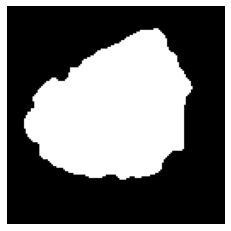

In [82]:
x_train, y_train = valid_gen.__getitem__(2)
preds_train = model.predict(x_train)
preds_train = preds_train > 0.2
plt.imshow(x_train[0])
plt.axis('off')
plt.savefig('resources/x_train_11.png',bbox_inches='tight')
plt.imshow(np.reshape(y_train[0]*255, (image_size, image_size)), cmap="gray")
plt.axis('off')
plt.savefig('resources/y_train_11.png',bbox_inches='tight')
plt.imshow(np.reshape(preds_train[0]*255, (image_size, image_size)), cmap="gray")
plt.axis('off')
plt.savefig('resources/preds_train_11.png',bbox_inches='tight')

x_train, y_train = valid_gen.__getitem__(0)
preds_train = model.predict(x_train)
preds_train = preds_train > 0.1
plt.imshow(x_train[0])
plt.axis('off')
plt.savefig('resources/x_train_12.png',bbox_inches='tight')
plt.imshow(np.reshape(y_train[0]*255, (image_size, image_size)), cmap="gray")
plt.axis('off')
plt.savefig('resources/y_train_12.png',bbox_inches='tight')
plt.imshow(np.reshape(preds_train[0]*255, (image_size, image_size)), cmap="gray")
plt.axis('off')
plt.savefig('resources/preds_train_12.png',bbox_inches='tight')

## Evaluation

### Goal Metric

Predicted responses are scored using a threshold [Jaccard index](https://en.wikipedia.org/wiki/Jaccard_index) metric.

To compute this metric:

* For each image, a pixel-wise comparison of each predicted segmentation with the corresponding ground truth segmentation is made using the Jaccard index.
* The final score for each image is computed as a threshold of the Jaccard according to the following:
  * score = 0, if the Jaccard index is less than 0.65
  * score = the Jaccard index value, otherwise
* The mean of all per-image scores is taken as the final metric value for the entire dataset

### Other Metrics
For scientific completeness, predicted responses will also have the following metrics computed on a pixel-wise basis (comparing prediction vs. ground truth) for each image:

* sensitivity\
(specificity)\
(accuracy)\
(raw Jaccard index)\
Dice coefficient

NOTE:
The Dice coefficient is defined as:\
Dice = 2 * TP / ( 2 * TP + FP + FN )\
The Jaccard index is defined as:\
Jaccard = TP / ( TP + FP + FN )

In [ ]:
# custom metrics
def precision(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
def recall(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

In [120]:
def dice_coefficient(y_true, y_pred):
    y_true = np.asarray(y_true).astype(np.bool)
    y_pred = np.asarray(y_pred).astype(np.bool)
    intersection = np.logical_and(y_true, y_pred)
    return (2. * intersection.sum()) / (y_true.sum() + y_pred.sum())

def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def compute_dice(y_true, y_pred):

    mean_dice = 0.
    thresholded_dice = 0.

    for im_index in range(y_pred.shape[0]):

        current_dice = dice_coefficient(y_true=y_true[im_index], y_pred=y_pred[im_index])

        mean_dice += current_dice
        thresholded_dice += 0 if current_dice < 0.65 else current_dice

    mean_dice = mean_dice/y_pred.shape[0]
    thresholded_dice = thresholded_dice/y_pred.shape[0]

    return mean_dice, thresholded_dice

print(compute_dice(y, result))

(0.5528829143871203, 0.3994418199905895)


In [115]:
import numpy as np
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from sklearn.utils import compute_class_weight as sk_compute_class_weight


def jaccard(y_true, y_pred):
    intersect = np.sum(y_true * y_pred) # Intersection points
    union = np.sum(y_true) + np.sum(y_pred)  # Union points
    return (float(intersect))/(union - intersect +  1e-7)


def compute_jaccard(y_true, y_pred):

    mean_jaccard = 0.
    thresholded_jaccard = 0.

    for im_index in range(y_pred.shape[0]):

        current_jaccard = jaccard(y_true=y_true[im_index], y_pred=y_pred[im_index])

        mean_jaccard += current_jaccard
        thresholded_jaccard += 0 if current_jaccard < 0.65 else current_jaccard

    mean_jaccard = mean_jaccard/y_pred.shape[0]
    thresholded_jaccard = thresholded_jaccard/y_pred.shape[0]

    return mean_jaccard, thresholded_jaccard

print(compute_jaccard(y, result))

(0.5997353313588921, 0.5448625948967357)


# References

Data was extracted from the “ISIC 2018: Skin Lesion Analysis Towards Melanoma Detection” grand challenge datasets [1][2].

[1] Noel C. F. Codella, David Gutman, M. Emre Celebi, Brian Helba, Michael A. Marchetti, Stephen W. Dusza, Aadi Kalloo, Konstantinos Liopyris, Nabin Mishra, Harald Kittler, Allan Halpern: “Skin Lesion Analysis Toward Melanoma Detection: A Challenge at the 2017 International Symposium on Biomedical Imaging (ISBI), Hosted by the International Skin Imaging Collaboration (ISIC)”, 2017; arXiv:1710.05006.

[2] Tschandl, P., Rosendahl, C. & Kittler, H. The HAM10000 dataset, a large collection of multi-source dermatoscopic images of common pigmented skin lesions. Sci. Data 5, 180161 doi:10.1038/sdata.2018.161 (2018).

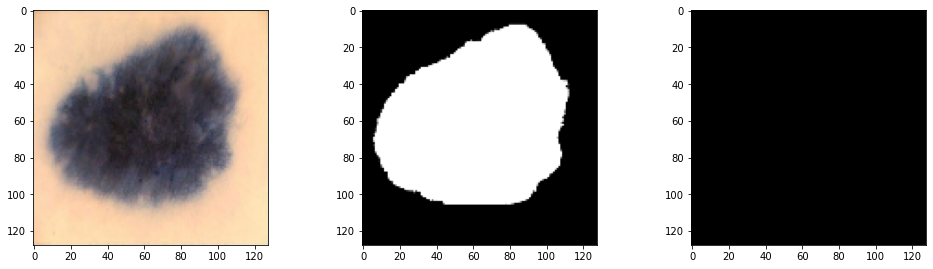

In [118]:
gen = DataGen(test_ids, path,10,128)
x, y = gen.__getitem__(0)
result = model.predict(x)

result = result > 0.5
fig = plt.figure(figsize = (16,8))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 3, 1)
ax.imshow(x[0])
ax = fig.add_subplot(1, 3, 2)
ax.imshow(np.reshape(y[0]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 3, 3)
ax.imshow(np.reshape(result[0]*255, (image_size, image_size)), cmap="gray")

In [119]:
import numpy as np
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from sklearn.utils import compute_class_weight as sk_compute_class_weight


def jaccard(y_true, y_pred):
    intersect = np.sum(y_true * y_pred) # Intersection points
    union = np.sum(y_true) + np.sum(y_pred)  # Union points
    return (float(intersect))/(union - intersect +  1e-7)


def compute_jaccard(y_true, y_pred):

    mean_jaccard = 0.
    thresholded_jaccard = 0.

    for im_index in range(y_pred.shape[0]):

        current_jaccard = jaccard(y_true=y_true[im_index], y_pred=y_pred[im_index])

        mean_jaccard += current_jaccard
        thresholded_jaccard += 0 if current_jaccard < 0.65 else current_jaccard

    mean_jaccard = mean_jaccard/y_pred.shape[0]
    thresholded_jaccard = thresholded_jaccard/y_pred.shape[0]

    return mean_jaccard, thresholded_jaccard

mean_jaccard, thresholded_jaccard = compute_jaccard(y, result)
print("平均:")
print(mean_jaccard)
print("最差:")
print(thresholded_jaccard)

平均:
0.44856012198852246
最差:
0.2868628600651441
